# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [216]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [217]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [218]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [219]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [221]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [222]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import math

In [223]:
data = data.applymap(pd.to_numeric, errors='coerce')
holdout_data = holdout_data.applymap(pd.to_numeric, errors='coerce')
data.replace('?', np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)
holdout_data.replace('?', np.nan, inplace=True)
holdout_data.fillna(holdout_data.mean(), inplace=True)
df = data.values
out = holdout_data.values

data.describe()
X=df[:, :-2]
X = StandardScaler().fit_transform(X)
y=df[:, -2]
X_data=data.iloc[:,:-2]
y_data=data.iloc[:, -2]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
count,4818.000000,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,...,4818.000000,4818.000000,4818.000000,4.818000e+03,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927,3499.858032
std,6.705958,1.202660,1.282164,100.117705,2.382015e+04,7.776908,6.706577,109.348749,1.342723,4.043196,...,7.247517,0.932427,6.337285,6.942383e+04,43.766529,2279.713700,113.049493,583.617986,0.244648,1392.049260
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000,1071.000000
25%,0.004042,0.254765,0.044978,1.101525,-4.290075e+01,0.000000,0.005977,0.482350,1.015600,0.319095,...,0.015582,0.876940,0.000000,5.456550e+00,4.236425,45.065750,3.077000,2.137425,0.000000,2296.250000
50%,0.046428,0.451610,0.218155,1.645450,4.932050e-01,0.000000,0.056653,1.154350,1.140500,0.522195,...,0.108860,0.950825,0.006365,9.449650e+00,6.181450,73.879500,4.939500,4.224000,0.000000,3500.500000
75%,0.116725,0.662140,0.420033,2.943000,4.978025e+01,0.110387,0.135972,2.814600,1.814050,0.721670,...,0.240200,0.990358,0.208242,1.968150e+01,9.342925,118.597500,8.097875,9.834275,0.000000,4704.750000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000,5909.000000


Visualize data, and find that the data is imbalanced, and the features have high correlation.

<AxesSubplot:>

Text(0.5, 1.0, 'Not Bankrupt(0) vs Bankrupt(1)')

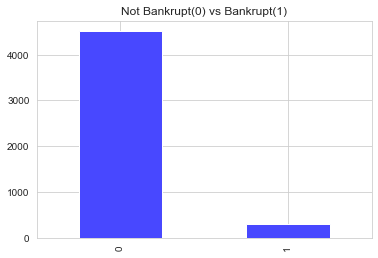

In [224]:
import seaborn as sns
y_data.value_counts().plot(kind='bar')
sns.set_style('whitegrid')
sns.set_palette('bwr')
plt.title('Not Bankrupt(0) vs Bankrupt(1)')
plt.show()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1118500.,  -821640.,  -524780.,  -227920.,    68940.,   365800.,
          662660.,   959520.,  1256380.,  1553240.,  1850100.,  2146960.,
         2443820.,  2740680.,  3037540.,  3334400.,  3631260.,  3928120.,
         4224980.,  4521840.,  4818700.]),
 <a list of 66 BarContainer objects>)

Text(0.5, 0, 'bankrupt')

Text(0.5, 1.0, 'Histogram of Data')

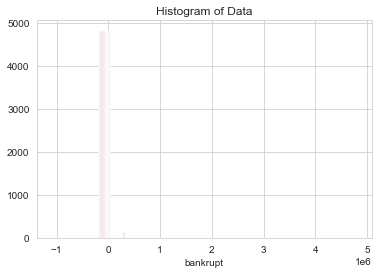

In [225]:
plt.hist(data, bins=20, alpha=0.5)
plt.xlabel('bankrupt')
plt.title('Histogram of Data')
plt.show()

<AxesSubplot:>

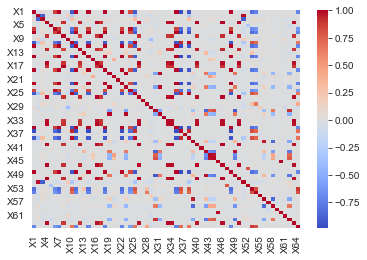

In [226]:
corr_matrix = X_data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

Here I use randomoversampler to do random oversampling, and use PCA to lower the dimenision since we have dataset with features having high correlation with each other.

In [227]:
from imblearn.over_sampling import RandomOverSampler
# Random oversampling
# ros = RandomOverSampler(random_state=42)
# X_ros, y_ros = ros.fit_resample(X, y)

In [228]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_ros, y_ros = smote.fit_resample(X, y)
# X_ros, y_ros = X, y

array([[-0.34702704, -0.5294126 , -0.12070429],
       [-0.21829935, -0.92479567, -0.042012  ],
       [-0.33985283, -0.5397412 , -0.10783738],
       ...,
       [-0.33001267, -0.63287133, -0.10503977],
       [-0.64097052,  5.50196878,  0.01719125],
       [-0.4842435 ,  2.82453162, -0.05874599]])

array([[-0.34702704, -0.5294126 , -0.12070446, -0.21890153],
       [-0.21829935, -0.92479566, -0.04201228, -0.08630411],
       [-0.33985283, -0.5397412 , -0.10783744, -0.16917529],
       ...,
       [-0.33001267, -0.63287132, -0.10503991, -0.14392463],
       [-0.64097052,  5.50196878,  0.01719121, -0.33927061],
       [-0.4842435 ,  2.82453162, -0.05874571,  0.33723789]])

array([[-0.34702704, -0.5294126 , -0.12070433, -0.21890147, -0.09078057],
       [-0.21829935, -0.92479567, -0.04201203, -0.08630399, -0.11168285],
       [-0.33985283, -0.5397412 , -0.10783738, -0.16917527, -0.09423042],
       ...,
       [-0.33001267, -0.63287133, -0.10503983, -0.14392461, -0.0983891 ],
       [-0.64097052,  5.50196878,  0.01719124, -0.33927061, -0.11634374],
       [-0.4842435 ,  2.82453162, -0.0587459 ,  0.33723779, -0.10826753]])

array([[-0.34702704, -0.5294126 , -0.12070435, -0.21890146, -0.09078041,
        -0.16843581],
       [-0.21829935, -0.92479567, -0.04201212, -0.08630402, -0.1116825 ,
        -0.02323965],
       [-0.33985283, -0.5397412 , -0.10783739, -0.16917527, -0.09423032,
         0.0285762 ],
       ...,
       [-0.33001267, -0.63287133, -0.10503984, -0.1439246 , -0.09838902,
        -0.04076541],
       [-0.64097052,  5.50196878,  0.01719122, -0.33927061, -0.1163436 ,
         0.22480198],
       [-0.4842435 ,  2.82453162, -0.05874586,  0.33723778, -0.10826759,
         0.31957852]])

array([[-0.34702704, -0.52941245, -0.12068359, ..., -0.09082913,
        -0.16850317, -0.05063857],
       [-0.21829935, -0.92479554, -0.04198192, ..., -0.11172567,
        -0.02317936, -0.16056877],
       [-0.33985283, -0.53974118, -0.10782685, ..., -0.09426399,
         0.0285275 , -0.12410415],
       ...,
       [-0.33001267, -0.6328712 , -0.10502834, ..., -0.09841862,
        -0.04073099, -0.11927758],
       [-0.64097052,  5.50196872,  0.01718982, ..., -0.11633627,
         0.22484871,  0.0143288 ],
       [-0.4842435 ,  2.82453104, -0.05877616, ..., -0.10821046,
         0.31964974, -0.22565483]])

array([[-0.34702704, -0.52941328, -0.1206977 , ..., -0.16850781,
        -0.05143868, -0.98855023],
       [-0.21829934, -0.92479696, -0.04201347, ..., -0.02361318,
        -0.16170055, -1.05578727],
       [-0.33985283, -0.53974139, -0.10783462, ...,  0.02849446,
        -0.12425584, -0.83466731],
       ...,
       [-0.33001267, -0.63287163, -0.10503816, ..., -0.04087383,
        -0.11955108, -0.91356111],
       [-0.64097052,  5.50196884,  0.01718746, ...,  0.2246079 ,
         0.01491126,  1.42681787],
       [-0.4842435 ,  2.8245332 , -0.05875547, ...,  0.31960156,
        -0.22320683,  0.67079932]])

array([[-0.34702704, -0.52941306, -0.12070343, ..., -0.0518637 ,
        -0.98705833, -0.11310071],
       [-0.21829935, -0.92479574, -0.04201494, ..., -0.1624393 ,
        -1.05525658,  0.16568577],
       [-0.33985283, -0.53974145, -0.10783528, ..., -0.12458961,
        -0.83432768,  0.02689917],
       ...,
       [-0.33001267, -0.63287144, -0.10504004, ..., -0.11992719,
        -0.9132293 ,  0.0747996 ],
       [-0.64097052,  5.50196888,  0.01719085, ...,  0.0144108 ,
         1.42543029,  0.1032307 ],
       [-0.4842435 ,  2.82453211, -0.05874651, ..., -0.22310087,
         0.66871283,  0.98091563]])

array([[-0.34702704, -0.5294128 , -0.12069869, ..., -0.98769512,
        -0.11281608,  0.05917408],
       [-0.21829935, -0.9247961 , -0.04200402, ..., -1.05534169,
         0.16546695,  0.12846864],
       [-0.33985283, -0.53974118, -0.10783424, ..., -0.83441427,
         0.02719744, -0.07597102],
       ...,
       [-0.33001267, -0.6328715 , -0.10503569, ..., -0.91324374,
         0.07529608,  0.0420146 ],
       [-0.64097052,  5.50196873,  0.01719207, ...,  1.42586675,
         0.10309382,  0.0128182 ],
       [-0.4842435 ,  2.82453172, -0.05875035, ...,  0.66932676,
         0.97972037,  0.08135583]])

array([[-3.47027039e-01, -5.29412685e-01, -1.20699544e-01, ...,
        -1.11517107e-01,  5.93991635e-02, -1.68924775e-02],
       [-2.18299348e-01, -9.24795420e-01, -4.20147583e-02, ...,
         1.65733838e-01,  1.32461064e-01, -2.24899050e-02],
       [-3.39852831e-01, -5.39741158e-01, -1.07835950e-01, ...,
         2.81278920e-02, -7.39284067e-02, -1.91463281e-02],
       ...,
       [-3.30012669e-01, -6.32871345e-01, -1.05037204e-01, ...,
         7.58789336e-02,  4.13271352e-02, -1.74067240e-02],
       [-6.40970518e-01,  5.50196897e+00,  1.71887731e-02, ...,
         1.03096969e-01,  1.55479797e-02, -3.55331324e-03],
       [-4.84243502e-01,  2.82453167e+00, -5.87494243e-02, ...,
         9.78990404e-01,  8.03713337e-02, -2.32655401e-03]])

array([[-3.47027040e-01, -5.29413023e-01, -1.20703289e-01, ...,
         6.69069543e-02, -1.65947970e-02, -1.44337700e-01],
       [-2.18299348e-01, -9.24795776e-01, -4.20119396e-02, ...,
         1.33443195e-01, -1.83538595e-02, -1.87393272e-01],
       [-3.39852832e-01, -5.39741076e-01, -1.07837891e-01, ...,
        -7.26311561e-02, -1.85338591e-02, -9.32771992e-02],
       ...,
       [-3.30012669e-01, -6.32871764e-01, -1.05038738e-01, ...,
         4.65824211e-02, -1.66394255e-02, -1.12236824e-01],
       [-6.40970518e-01,  5.50196889e+00,  1.71907413e-02, ...,
         1.23675886e-02, -2.45102279e-03, -5.54696248e-02],
       [-4.84243500e-01,  2.82453250e+00, -5.87482612e-02, ...,
         7.08622932e-02,  1.52514649e-04,  2.27529402e-02]])

array([[-3.47027039e-01, -5.29412905e-01, -1.20701150e-01, ...,
        -1.72574215e-02, -1.50999829e-01,  2.69284207e-02],
       [-2.18299348e-01, -9.24795711e-01, -4.20113210e-02, ...,
        -1.89346969e-02, -1.88736346e-01,  6.86057322e-02],
       [-3.39852831e-01, -5.39741326e-01, -1.07836291e-01, ...,
        -1.94363533e-02, -9.25567738e-02, -8.23755325e-02],
       ...,
       [-3.30012669e-01, -6.32871403e-01, -1.05039065e-01, ...,
        -1.83617355e-02, -1.17676237e-01,  1.42789938e-02],
       [-6.40970518e-01,  5.50196887e+00,  1.71897661e-02, ...,
        -3.08284205e-03, -5.37507084e-02, -2.10783550e-01],
       [-4.84243501e-01,  2.82453189e+00, -5.87491309e-02, ...,
         3.84240753e-04,  3.67187876e-02, -2.11816825e-01]])

array([[-0.34702704, -0.52941231, -0.12070183, ..., -0.15193617,
         0.03774148, -0.21403933],
       [-0.21829935, -0.92479561, -0.04201121, ..., -0.18931828,
         0.07235993, -0.28236281],
       [-0.33985283, -0.53974119, -0.10783757, ..., -0.09407759,
        -0.07816691, -0.10375777],
       ...,
       [-0.33001267, -0.63287122, -0.10503855, ..., -0.11719106,
         0.015456  , -0.16100972],
       [-0.64097052,  5.50196859,  0.01719042, ..., -0.05050687,
        -0.21466591,  0.01910377],
       [-0.4842435 ,  2.82453114, -0.05875075, ...,  0.03520002,
        -0.22296595,  0.25793881]])

array([[-0.34702704, -0.52941272, -0.1207061 , ...,  0.04004684,
        -0.25046485, -0.03870925],
       [-0.21829935, -0.92479566, -0.04201228, ...,  0.07328083,
        -0.30732665, -0.07216938],
       [-0.33985283, -0.53974122, -0.10783765, ..., -0.07711392,
        -0.116868  , -0.02025658],
       ...,
       [-0.33001267, -0.63287131, -0.10503967, ...,  0.01671997,
        -0.17386138, -0.04966459],
       [-0.64097052,  5.501969  ,  0.0171947 , ..., -0.21498875,
         0.03393765, -0.10735194],
       [-0.4842435 ,  2.82453169, -0.05874495, ..., -0.22641807,
         0.27595116, -0.01687161]])

array([[-0.34702704, -0.5294126 , -0.12070438, ..., -0.21808118,
        -0.09035346,  0.32674327],
       [-0.21829935, -0.92479567, -0.04201212, ..., -0.2818539 ,
        -0.1259424 ,  0.55092647],
       [-0.33985283, -0.5397412 , -0.10783738, ..., -0.10537332,
        -0.04312399,  0.13349615],
       ...,
       [-0.33001267, -0.63287133, -0.10503982, ..., -0.16157995,
        -0.07906992,  0.20920083],
       [-0.64097052,  5.50196879,  0.01719146, ...,  0.02402618,
        -0.09048379,  0.05392862],
       [-0.4842435 ,  2.82453162, -0.0587459 , ...,  0.26066704,
         0.03700497, -0.56553487]])

array([[-3.47027039e-01, -5.29412606e-01, -1.20704394e-01, ...,
        -9.02279498e-02,  3.26701502e-01, -8.34649662e-04],
       [-2.18299348e-01, -9.24795666e-01, -4.20120659e-02, ...,
        -1.26051019e-01,  5.50792993e-01,  1.01674318e-01],
       [-3.39852831e-01, -5.39741195e-01, -1.07837378e-01, ...,
        -4.32977141e-02,  1.34041453e-01,  1.41089673e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039833e-01, ...,
        -7.90832534e-02,  2.10089628e-01, -1.99171470e-02],
       [-6.40970518e-01,  5.50196880e+00,  1.71911929e-02, ...,
        -9.10700146e-02,  5.74238947e-02, -1.05169903e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458606e-02, ...,
         3.72386573e-02, -5.66191624e-01, -4.31142129e-02]])

array([[-3.47027039e-01, -5.29412598e-01, -1.20704302e-01, ...,
         3.26804753e-01, -7.29004738e-04,  1.48346853e-01],
       [-2.18299348e-01, -9.24795672e-01, -4.20121656e-02, ...,
         5.50652842e-01,  1.01528754e-01, -2.18545862e-02],
       [-3.39852831e-01, -5.39741206e-01, -1.07837437e-01, ...,
         1.33831862e-01,  1.39543322e-02,  2.42385556e-02],
       ...,
       [-3.30012669e-01, -6.32871329e-01, -1.05039822e-01, ...,
         2.09873646e-01, -2.02450197e-02,  1.14161925e-01],
       [-6.40970518e-01,  5.50196877e+00,  1.71910619e-02, ...,
         5.73735256e-02, -1.13723765e-02, -3.01687714e-02],
       [-4.84243501e-01,  2.82453163e+00, -5.87457533e-02, ...,
        -5.66378307e-01, -4.30119172e-02, -3.08177196e-01]])

array([[-3.47027039e-01, -5.29412603e-01, -1.20704364e-01, ...,
        -1.05266683e-03,  1.48216539e-01, -6.70936194e-02],
       [-2.18299348e-01, -9.24795668e-01, -4.20121106e-02, ...,
         1.01671931e-01, -2.15955920e-02, -9.14932090e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837386e-01, ...,
         1.45001333e-02,  2.42033251e-02, -6.79165429e-03],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039841e-01, ...,
        -1.99282083e-02,  1.13908985e-01, -7.00843757e-02],
       [-6.40970518e-01,  5.50196879e+00,  1.71912296e-02, ...,
        -9.43611290e-03, -3.01354897e-02, -2.18877639e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458433e-02, ...,
        -4.32656897e-02, -3.08522604e-01,  1.26890118e-01]])

array([[-0.34702704, -0.5294126 , -0.12070436, ...,  0.14795203,
        -0.06804614, -0.0224906 ],
       [-0.21829935, -0.92479567, -0.04201211, ..., -0.02144196,
        -0.09090399, -0.01682625],
       [-0.33985283, -0.5397412 , -0.10783739, ...,  0.02441759,
        -0.00588508, -0.02775384],
       ...,
       [-0.33001267, -0.63287133, -0.10503984, ...,  0.11385383,
        -0.07024068,  0.01634468],
       [-0.64097052,  5.50196878,  0.01719122, ..., -0.02962179,
        -0.01929744, -0.00618197],
       [-0.4842435 ,  2.82453162, -0.05874584, ..., -0.30866929,
         0.12568747, -0.02955657]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704354e-01, ...,
        -6.81250200e-02, -2.25037149e-02, -7.80694623e-03],
       [-2.18299348e-01, -9.24795669e-01, -4.20121174e-02, ...,
        -9.08159350e-02, -1.68060955e-02, -7.24264828e-03],
       [-3.39852831e-01, -5.39741201e-01, -1.07837390e-01, ...,
        -5.91658840e-03, -2.77666992e-02, -1.39341159e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039838e-01, ...,
        -7.02689038e-02,  1.63381287e-02, -4.28335323e-03],
       [-6.40970518e-01,  5.50196878e+00,  1.71912283e-02, ...,
        -1.95031105e-02, -6.21302884e-03, -1.01132832e-02],
       [-4.84243501e-01,  2.82453163e+00, -5.87458511e-02, ...,
         1.25584260e-01, -2.96633329e-02, -1.35773460e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704360e-01, ...,
        -2.24923029e-02, -7.78078085e-03, -3.73304612e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121120e-02, ...,
        -1.68246908e-02, -7.28451446e-03, -5.73971238e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
        -2.77559695e-02, -1.39115836e-02, -1.14397481e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
         1.63425226e-02, -4.27524740e-03, -4.49003419e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912129e-02, ...,
        -6.17272489e-03, -1.00345373e-02, -1.25742087e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458411e-02, ...,
        -2.95536477e-02, -1.34182032e-02,  4.90716473e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -7.77570734e-03, -3.73413459e-02, -2.96149554e-01],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
        -7.28875043e-03, -5.73805444e-02, -8.09123148e-03],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
        -1.39096772e-02, -1.14430764e-02, -1.57132462e-01],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -4.27265204e-03, -4.48989031e-02, -8.53389707e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912178e-02, ...,
        -1.00192763e-02, -1.26009981e-02,  8.03682035e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458430e-02, ...,
        -1.34201195e-02,  4.90485278e-02,  3.43076783e-01]])

array([[-0.34702704, -0.5294126 , -0.12070436, ..., -0.03734635,
        -0.29614584,  0.07262133],
       [-0.21829935, -0.92479567, -0.04201211, ..., -0.05738119,
        -0.00808777,  0.03595071],
       [-0.33985283, -0.5397412 , -0.10783739, ..., -0.01144413,
        -0.15713491,  0.00562629],
       ...,
       [-0.33001267, -0.63287133, -0.10503984, ..., -0.04490574,
        -0.08533316,  0.04580044],
       [-0.64097052,  5.50196878,  0.01719122, ..., -0.01262596,
         0.0804111 , -0.05184026],
       [-0.4842435 ,  2.82453162, -0.05874584, ...,  0.04908866,
         0.34300805, -0.03876959]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -2.96146048e-01,  7.26216401e-02, -6.39566655e-04],
       [-2.18299348e-01, -9.24795669e-01, -4.20121137e-02, ...,
        -8.08863626e-03,  3.59509194e-02,  2.39884696e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
        -1.57137026e-01,  5.62803252e-03,  1.09016126e-01],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -8.53363825e-02,  4.58032596e-02, -1.60490921e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
         8.03793366e-02, -5.18102674e-02, -2.81283940e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
         3.43031547e-01, -3.87934314e-02,  1.43002363e-01]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
         7.26211083e-02, -6.38582493e-04,  3.91950999e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
         3.59512189e-02,  2.39874451e-02, -7.32905196e-03],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         5.62846936e-03,  1.09014579e-01,  1.54242234e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
         4.58032344e-02, -1.60498856e-02, -3.28578948e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
        -5.18053327e-02, -2.81221774e-02, -1.83692921e-01],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
        -3.87936826e-02,  1.43001092e-01,  5.66259229e-03]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
        -6.38524506e-04,  3.91951788e-02,  6.93822658e-03],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
         2.39873999e-02, -7.32881563e-03, -8.65998326e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         1.09014485e-01,  1.54245020e-02,  9.57866273e-03],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -1.60499936e-02, -3.28573387e-02, -2.55545153e-03],
       [-6.40970518e-01,  5.50196878e+00,  1.71912180e-02, ...,
        -2.81218195e-02, -1.83710800e-01,  1.18005887e-01],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
         1.43000643e-01,  5.66932538e-03, -9.37292924e-03]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
         3.91970659e-02,  6.93834593e-03,  5.42029537e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121137e-02, ...,
        -7.32751547e-03, -8.65992152e-02, -5.09831805e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         1.54236122e-02,  9.57926357e-03, -2.72250951e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -3.28562457e-02, -2.55427391e-03,  3.55598628e-03],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
        -1.83705439e-01,  1.17989000e-01, -1.99847235e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
         5.66717301e-03, -9.36153606e-03,  4.37570727e-02]])

array([[-3.47027039e-01, -5.29412602e-01, -1.20704358e-01, ...,
         6.93790740e-03,  5.42090325e-02, -4.13732173e-02],
       [-2.18299348e-01, -9.24795669e-01, -4.20121138e-02, ...,
        -8.65990887e-02, -5.09727753e-02,  5.16096761e-02],
       [-3.39852831e-01, -5.39741201e-01, -1.07837391e-01, ...,
         9.57970907e-03, -2.72242248e-02,  3.18592056e-02],
       ...,
       [-3.30012669e-01, -6.32871328e-01, -1.05039840e-01, ...,
        -2.55393253e-03,  3.56838760e-03, -2.51509646e-02],
       [-6.40970518e-01,  5.50196878e+00,  1.71912179e-02, ...,
         1.17989030e-01, -1.99811449e-02,  8.99564032e-02],
       [-4.84243501e-01,  2.82453162e+00, -5.87458431e-02, ...,
        -9.36182091e-03,  4.37626895e-02, -7.72979688e-02]])

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Total explained variance')

Text(0.5, 1.0, 'Total explained variance per components')

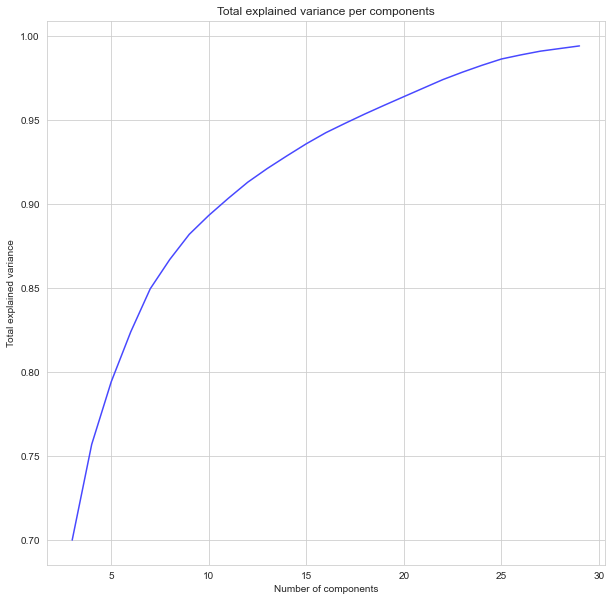

In [229]:
# Deciding the number of components for PCA
temp = []
n_components = np.arange(3,30)
for n in n_components:
    pca = PCA(n_components = n)
    pca.fit_transform(X_ros)
    total_variance = pca.explained_variance_ratio_.sum()
    temp.append(total_variance)

sns.set_style('whitegrid')
sns.set_palette('bwr')
plt.figure(figsize = (10,10))
plt.plot(n_components, temp)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.title('Total explained variance per components')
plt.show()

We can see from the plot that the first 3 components have already explained 80% variance.

In [230]:
scaler = StandardScaler()
X_scaled_ros = scaler.fit_transform(X_ros)
pca = PCA(n_components=15)
X_pca_ros = pca.fit_transform(X_scaled_ros)

Since gridsearch takes quite a long time, I use randomsearch instead.

In [231]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn import svm
from sklearn.svm import SVC
param_dist = {'C': [1, 10, 20], 'gamma': [0.1, 0.5], 'kernel': ['linear', 'rbf']}
svm = svm.SVC(kernel='linear')
n_iter_search = 10
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=n_iter_search, cv=5)
random_search.fit(X_ros, y_ros)
print("Best hyperparameters: {}".format(random_search.best_params_))
print("Best score: {:.2f}".format(random_search.best_score_))

RandomizedSearchCV(cv=5, estimator=SVC(kernel='linear'),
                   param_distributions={'C': [1, 10, 20], 'gamma': [0.1, 0.5],
                                        'kernel': ['linear', 'rbf']})

Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.5, 'C': 20}
Best score: 0.95


In [232]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.svm import SVC
print("SVM")
svm_model=SVC(C=20, gamma=0.5)
X_train, X_test, y_train, y_test = train_test_split(X_pca_ros, y_ros, test_size=0.1, random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

SVM


SVC(C=20, gamma=0.5)

In [233]:
name = "SVM model"

accuracy_test = accuracy_score(y_test, svm_pred)
recall_test = recall_score(y_test, svm_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   svm_pred, pos_label=1, average="binary", zero_division=1)

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	SVM model Accuracy: 83.9%, Recall 84.1%, Precision 83.5%


<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for SVM')

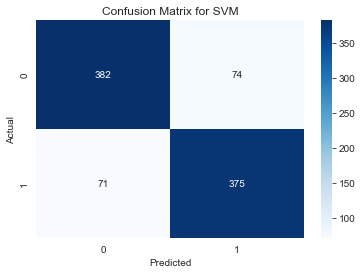

In [234]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

In [235]:
from sklearn.metrics import classification_report
print("Neural network")
print("iteration : 50000")
logistic_activation = MLPClassifier(activation = 'logistic', hidden_layer_sizes = (90,90,3), solver = "sgd", 
                                    random_state=1, max_iter=50000)
logistic_activation.fit(X_train, y_train)
logis_pred = logistic_activation.predict(X_test)
score_logis = accuracy_score(logis_pred, y_test)
print("sigmoid activation function test accuracy:", score_logis)

Neural network
iteration : 50000


MLPClassifier(activation='logistic', hidden_layer_sizes=(90, 90, 3),
              max_iter=50000, random_state=1, solver='sgd')

sigmoid activation function test accuracy: 0.4911308203991131


In [236]:
name = "Neural network model"

accuracy_test = accuracy_score(y_test, logis_pred)
recall_test = recall_score(y_test, logis_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   logis_pred, pos_label=1, average="binary", zero_division=1)

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	Neural network model Accuracy: 49.1%, Recall 99.3%, Precision 49.3%


<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for Neural Network')

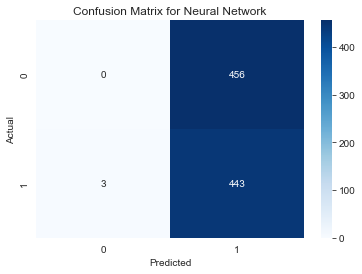

In [237]:
cm = confusion_matrix(y_test, logis_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Neural Network')
plt.show()

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [238]:
import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    
    # YOUR CODE GOES HERE
    model = tree.DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42)
    model = model.fit(X_train, y_train)
    
    predictions = model.predict(X)
    return predictions


In [239]:
#random_out=holdout_data.iloc[:, :-1]
#X_test=random_out.sample(n=482,axis='rows')

In [240]:
name = "My best model---Decision tree model: "
y_test_pred = MyModel(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test, y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	My best model---Decision tree model:  Accuracy: 84.6%, Recall 90.1%, Precision 80.9%


<AxesSubplot:>

Text(0.5, 16.0, 'Predicted')

Text(34.0, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix for Decision tree')

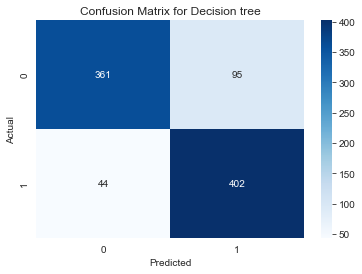

In [241]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision tree')
plt.show()

I choose decision tree as my best model as its recall and precision are more in line with my expectation.
As we know that "You may assume that it is 5 times worse to fail to identify a company that will go bankrupt than it is to fail to identify a company that won't go bankrupt", it indicates that we should have the recall higher than precision when trying to make trade-off between Recall and Precision. I set the test size to be small in order to achive this goal which larger proportion of the data will be used for training the model. Thus the model has more training data to learn from and can better capture the patterns in the data that are associated with the positive class. However, SVM model and neural network model fail to achieve this goal. I try to increase the penalty parameter of the error term of SVM model "c", but even I increase to 20000 recall is still smaller than precision. 